In [1]:
!pip install transformers
!pip install tensorflow_text

     |████████████████████████████████| 3.8 MB 5.1 MB/s 
     |████████████████████████████████| 6.5 MB 33.5 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 895 kB 43.6 MB/s 
     |████████████████████████████████| 596 kB 30.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 4.9 MB 4.7 MB/s 
     |████████████████████████████████| 462 kB 32.9 MB/s 


In [2]:
import tensorflow as tf
import pandas as pd
import transformers
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
#df = pd.read_csv("../Datasets/newsdata.csv", names = ["Category", "Text"])
df = pd.read_csv("/content/drive/My Drive/FYP/newsdata.csv", names = ["Category", "Text"], delimiter="\t")
df.head()

,Category,Text
0,Crypto,Ukrainian Crypto Rainmaker To Testify In Senat...
1,Crypto,Ukraines Government Launches Official Website ...
2,Crypto,"Bitcoin, Ether, Dogecoin spikes in price after..."
3,Crypto,"Bit Digital, Inc. Announces Bitcoin Production..."
4,Crypto,The-future-of-crypto-is-boring and-bright


In [24]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,Category,Text
4697,EVs,"Euler Motors, TWU to deploy 1,000 electric thr..."
5243,EVs,Coalition's reluctance to cash in on EVs slamm...
3102,Oil,"Mackay Shields LLC Sells 3,488 Shares of Marat..."
1381,Crypto,Crypto industry wants govt to relook at 30% ta...
2377,Oil,Oil prices fall on fears of aggressive Fed rat...


In [25]:
df.Category.unique()

array(['EVs', 'Oil', 'Crypto', 'Gaming', 'Tech'], dtype=object)

In [26]:
df["Category"] = df["Category"].replace({'Crypto': 0, 'Oil': 1, 'EVs': 2, 'Tech': 3, 'Gaming': 4})

#Category-wise data point counts
df["Category"].value_counts()

4    3048
2    2704
1    1896
0    1441
3    1415
Name: Category, dtype: int64

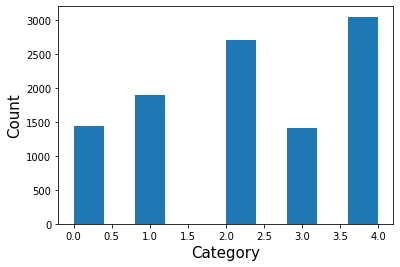

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('Category', fontsize=15)
ax.set_ylabel('Count', fontsize=15)

df.Category.hist(ax=ax,grid=False, bins= 10)
plt.show()

In [28]:
e_df = df

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(e_df, 
                                   random_state = 0,
                                   test_size = 0.2)

In [30]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [31]:
def convert_data(train, test, DATA_COL, LABEL_COL):
    
    train_input = train.apply(lambda x: InputExample(guid = None,
                                                    text_a = x[DATA_COL],
                                                    text_b = None,
                                                    label = x[LABEL_COL],
                                                    ), axis = 1)
    
    test_input = test.apply(lambda x: InputExample(guid = None,
                                                   text_a = x[DATA_COL],
                                                   text_b = None,
                                                   label = x[LABEL_COL],
                                                   ), axis = 1)
    
    return train_input, test_input

In [32]:
def convert_to_tf_dataset(input_data, tokenizer, max_length = 200):
    features = []
    
    for i in input_data:
        input_dict = tokenizer.encode_plus(
            i.text_a,
            add_special_tokens = True,
            max_length = max_length,
            return_token_type_ids = True,
            return_attention_mask = True,
            pad_to_max_length = True,
            truncation = True
        )
        
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"],
            input_dict["token_type_ids"],
            input_dict["attention_mask"]
        )
        
        features.append(InputFeatures(
            input_ids = input_ids, attention_mask = attention_mask,
            token_type_ids = token_type_ids, label = i.label))
        
    
    def gen():
        for f in features:
            yield({
                "input_ids": f.input_ids,
                "attention_mask": f.attention_mask,
                "token_type_ids": f.token_type_ids
            }, f.label)
            
    
    return tf.data.Dataset.from_generator(
        gen, ({"input_ids": tf.int32, "attention_mask": tf.int32,
              "token_type_ids": tf.int32}, tf.int64),
            ({
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None])
            },
                tf.TensorShape([]), 
            ),)

DATA_COL = "Text"
LABEL_COL = "Category"

In [33]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [34]:
train, test = convert_data(x_train, x_test, DATA_COL, LABEL_COL)

In [43]:
train_data = convert_to_tf_dataset(list(train), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

test_data = convert_to_tf_dataset(list(test), tokenizer).batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [47]:
test_data

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [48]:
train_data

<RepeatDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [46]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_74 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [49]:
model_metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name = "accuracy")
]

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = model_metrics)

history = model.fit(train_data, epochs = 1)

526/526 [==============================] - 1283s 2s/step - loss: 0.2245 - accuracy: 0.9336


In [50]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_74 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [51]:
y_pred = model.predict(test_data)

In [52]:
y_pred_argmax = np.argmax(y_pred[0], axis = 1)

In [53]:
y_true = x_test["Category"]

Text(33.0, 0.5, 'Ground Truth')

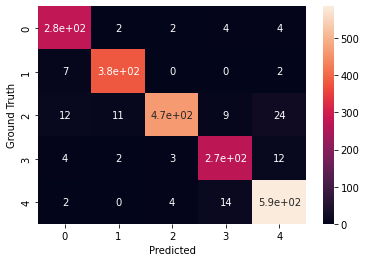

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred_argmax)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot = True)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

In [55]:
print(classification_report(y_true, y_pred_argmax))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       290
           1       0.96      0.98      0.97       389
           2       0.98      0.89      0.93       522
           3       0.91      0.93      0.92       294
           4       0.93      0.97      0.95       606

    accuracy                           0.94      2101
   macro avg       0.94      0.94      0.94      2101
weighted avg       0.94      0.94      0.94      2101



In [62]:
#Save the model

#model.save("/content/drive/My Drive/FYP/Models/bert-news-classifier-model")
tf.keras.models.save_model(model, "/content/drive/My Drive/FYP/Models/new-bert-news-classifier-model/saved_model", save_format="tf")

INFO:tensorflow:Assets written to: /content/drive/My Drive/FYP/Models/new-bert-news-classifier-model/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/FYP/Models/new-bert-news-classifier-model/saved_model/assets


In [63]:
#Load the model

#reconstructed_model = tf.keras.models.load_model("/content/drive/My Drive/FYP/Models/bert-news-classifier-model")
reconstructed_model = tf.keras.models.load_model("/content/drive/My Drive/FYP/Models/new-bert-news-classifier-model/saved_model")

In [64]:
reconstructed_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_74 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [65]:
y_pred = reconstructed_model.evaluate(test_data)
y_pred_argmax = np.argmax(y_pred[0], axis = 1)
y_true = x_test["Category"]

ValueError: ignored